In [75]:
from __future__ import annotations
import pandas as pd
import re
from glob import glob as glob  # glob
from tqdm import tqdm
from pelutils import Table, thousand_seps
from nltk.corpus import stopwords
from collections import Counter, defaultdict
import itertools
import random
import json
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("font", size=18)
mpl.rcParams["font.family"] = "Liberation Serif"

In [62]:
# https://insights.stackoverflow.com/survey/2020#technology-most-loved-dreaded-and-wanted-languages-loved
loved_languages = {
    "rust":        86.1,
    # "typescript":  67.1,
    "python":      66.7,
    "kotlin":      62.9,
    "go":          62.3,
    "julia":       62.2,
    "dart":        62.1,
    # "c#":          59.7,
    # "swift":       59.5,
    # "javascript":  58.3,
    # "scala":       53.2,
    # "haskell":     51.7,
    # "r":           44.5,
    # "java":        44.1,
    # "c++":         43.4,
    # "ruby":        42.9,
    # "php":         37.3,
    # "c":           33.1,
    # "assembly":    29.4,
    # "perl":        28.6,
    # "objective-c": 23.4,
    # "vba":         19.6,
}

In [63]:
# Collect all data into single dataframe

def lang(fpath: str) -> str:
    # Get programming language from a filepath
    return "-".join(fpath[fpath.index("/")+1:].split("-")[:-1])

qdfs = list()
adfs = list()
cdfs = list()
for qf, af, cf in tqdm(zip(
    glob("data/*-questions.pkl"),
    glob("data/*-answers.pkl"),
    glob("data/*-comments.pkl"),
), total=len(loved_languages)):
    qdfs.append(pd.read_pickle(qf))
    qdfs[-1]["language"] = lang(qf)
    qdfs[-1]["type"] = "q"
    adfs.append(pd.read_pickle(af))
    adfs[-1]["language"] = lang(af)
    adfs[-1]["type"] = "a"
    cdfs.append(pd.read_pickle(cf))
    cdfs[-1]["language"] = lang(cf)
    cdfs[-1]["type"] = "c"

# Shuffle to prevent systematic biases in contiguous subsets of dataframe
# TODO: Remove limit
so = pd.concat(qdfs + adfs + cdfs, ignore_index=True).sample(frac=1)[:10000]
del qdfs, adfs, cdfs

13it [00:01, 12.89it/s]


In [64]:
# Data summary
t = Table()
t.add_row(["Language", "Questions", "Answers", "Comments", "Total"])
for lang in loved_languages:
    t.add_row([
        lang.capitalize(),
        *[thousand_seps(sum((so["language"] == lang) & (so["type"] == t))) for t in ("q", "a", "c")],
        thousand_seps(sum(so["language"] == lang)),
    ], [1, 0, 0, 0, 0])
t.add_row([
    "",
    thousand_seps(sum(so["type"] == "q")),
    thousand_seps(sum(so["type"] == "a")),
    thousand_seps(sum(so["type"] == "c")),
    thousand_seps(len(so)),
], [1, 0, 0, 0, 0])
print(t)

Language | Questions | Answers | Comments | Total 
Rust     |       108 |     139 |      174 |    421
Python   |       190 |     351 |      426 |    967
Kotlin   |        54 |     105 |      132 |    291
Go       |       155 |     193 |      253 |    601
Julia    |        49 |      79 |       65 |    193
Dart     |        70 |     154 |      127 |    351
         |     1,998 |   3,435 |    4,567 | 10,000


In [65]:
# Regex for matching stopwords
sw = r"\b(" + "|".join(stopwords.words("english")) + r")\b"

def clean(text: str) -> str:
    # Remove link sections
    #text = re.sub(r"<pre><code>.*<\/pre><\/code>", "", text)
    # Remove links
    text = re.sub(r"\bhttp\S+", "", text)
    # Remove stopwords
    text = re.sub(sw, "", text)
    # Remove html tags
    text = re.sub(r"<.*?>", "", text)
    # Remove everything that is not alpha-numeric
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("Before cleaning")
print("  Words:         %s" % thousand_seps(words))
print("  Avg. per sub.: %.2f" % (words / len(so)))
print("  Characters:    %s" % thousand_seps(chars))
print("  Avg. per sub.: %.2f" % (chars / len(so)))

print("\nCleaning text")
so.body = [clean(body) for body in tqdm(so.body)]

words = sum(len(body.split()) for body in so.body)
chars = sum(len(body) for body in so.body)
print("\nAfter cleaning")
print("  Words:         %s" % thousand_seps(words))
print("  Avg. per sub.: %.2f" % (words / len(so)))
print("  Characters:    %s" % thousand_seps(chars))
print("  Avg. per sub.: %.2f" % (chars / len(so)))

  9%|▊         | 863/10000 [00:00<00:01, 8621.81it/s]Before cleaning
  Words:         843,683
  Avg. per sub.: 84.37
  Characters:    6,906,145
  Avg. per sub.: 690.61

Cleaning text
100%|██████████| 10000/10000 [00:01<00:00, 8077.75it/s]

After cleaning
  Words:         501,976
  Avg. per sub.: 50.20
  Characters:    4,630,779
  Avg. per sub.: 463.08


In [66]:
# Build lookup table to get all submissions with given question ID
subs_by_id = defaultdict(list)
for _, row in tqdm(so.iterrows(), total=len(so)):
    subs_by_id[row.question_id].append(row)
subs_by_id = { question_id: pd.DataFrame(rows) for question_id, rows in tqdm(subs_by_id.items()) }

100%|██████████| 9828/9828 [00:07<00:00, 1400.18it/s]


<ipython-input-67-9be58e316a4c>:2: RuntimeWarning: divide by zero encountered in log10
  def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):


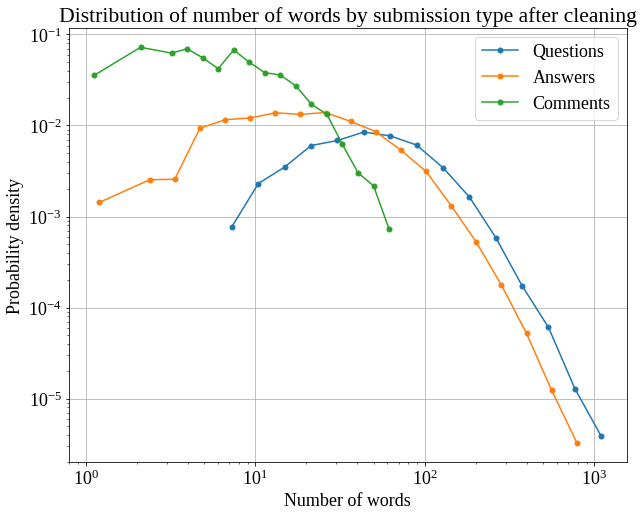

In [67]:
# Plot distribution of words
def bins(data, spacing=lambda x, b: np.logspace(0, max(np.log10(x)), b), bins=20):
    bins = spacing(data, bins+1)
    hist, edges = np.histogram(data, bins=bins, density=True)
    x = (edges[1:] + edges[:-1]) / 2
    xx, yy = x[hist>0], hist[hist>0]
    return xx, yy

qx, qdist = bins(np.array([len(body.split()) for body in so.body[so.type=="q"]]))
ax, adist = bins(np.array([len(body.split()) for body in so.body[so.type=="a"]]))
cx, cdist = bins(np.array([len(body.split()) for body in so.body[so.type=="c"]]))

fig, ax_ = plt.subplots(figsize=(10, 8))
ax_.plot(qx, qdist, marker=".", ms=10, label="Questions")
ax_.plot(ax, adist, marker=".", ms=10, label="Answers")
ax_.plot(cx, cdist, marker=".", ms=10, label="Comments")
ax_.grid(True)
ax_.set_xscale("log")
ax_.set_yscale("log")
ax_.set_title("Distribution of number of words by submission type after cleaning")
ax_.set_xlabel("Number of words")
ax_.set_ylabel("Probability density")
ax_.legend()

In [68]:
# Combine texts by programming language and split into train and validation
train_validation_split = 0.9
n_train_qs = int(train_validation_split * len(subs_by_id))
q_ids = list(subs_by_id)
q_ids_train = q_ids[:n_train_qs]
q_ids_val = q_ids[n_train_qs:]
train_texts = defaultdict(list)  # { language: List of all words from submissions tagged with that language }
validation_texts = defaultdict(list)  # { language: list of list of all words from a submission }

for i, (qid, subs) in tqdm(enumerate(subs_by_id.items()), total=len(subs_by_id)):
    lang = subs.iloc[0].language
    if lang not in loved_languages:
        continue
    if qid in q_ids_train:
        train_texts[lang] += list(itertools.chain(*(b.split() for b in subs.body)))
    else:
        validation_texts[lang].append(list(itertools.chain(*(b.split() for b in subs.body))))

100%|██████████| 9828/9828 [00:01<00:00, 5268.29it/s]


Text(0, 0.5, 'Number of words')

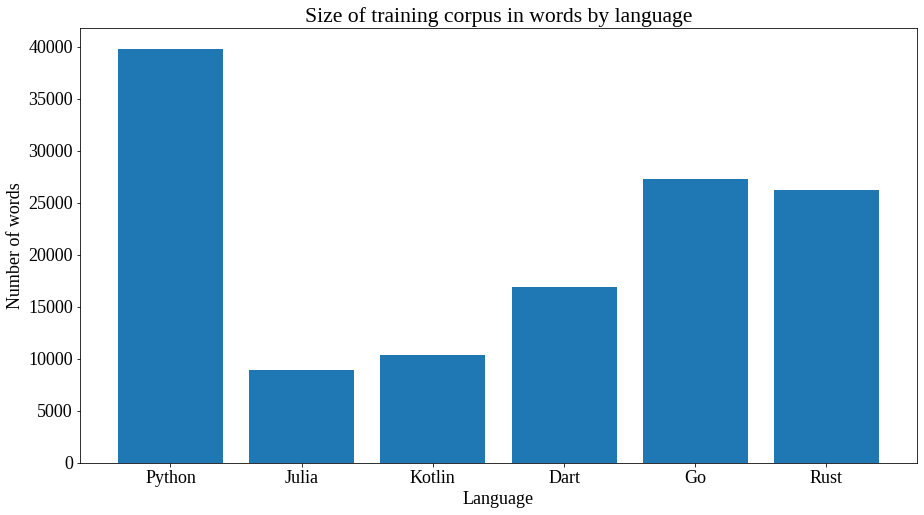

In [69]:
# Corpus size distribution
plt.figure(figsize=(15, 8))
plt.bar(range(len(loved_languages)), [len(corpus) for corpus in train_texts.values()], tick_label=[x.capitalize() for x in train_texts])
plt.title("Size of training corpus in words by language")
plt.xlabel("Language")
plt.ylabel("Number of words")

In [80]:
# Build classifier using TF-IDF

def top(counts: dict, n: int) -> dict:
    """ Takes a dict { key: count } and returns a dict with the n key-count pairs with highest counts """
    n_highest = sorted(counts.values())[-n] if n <= len(counts) else min(counts.values())
    return { key: count for key, count in counts.items() if count >= n_highest }

tfidf = dict()  # { language: { word: TF-IDF score } }
counts = { lang: Counter(train_texts[lang]) for lang in loved_languages }
for lang in tqdm(loved_languages):
    # Count of each for given language
    c = counts[lang]
    # Calculate TF and IDF
    tf = { word: count / len(train_texts[lang]) for word, count in c.items() }
    idf = {
        word: np.log(
            len(c) /\
            (1 + sum(word in vocab for vocab in counts.values()))
        )
        for word in c
    }
    tfidf[lang] = { word: tf[word] * idf[word] for word in c }

with open(os.path.join("data", "tfidf.json"), "w", encoding="utf-8") as f:
    json.dump(tfidf, f)

100%|██████████| 6/6 [00:00<00:00, 68.54it/s]


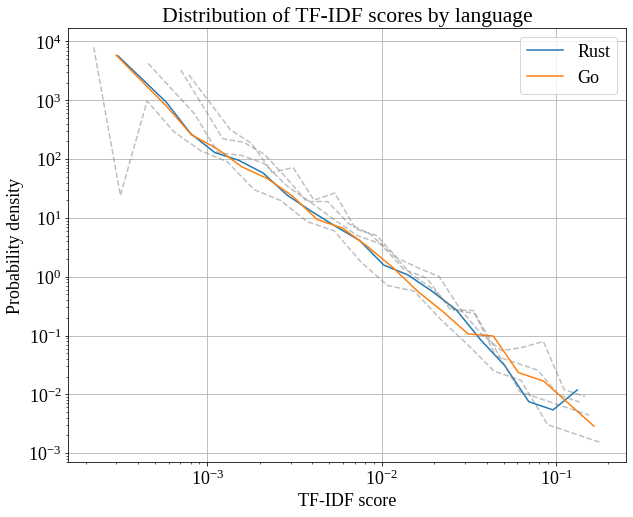

In [71]:
plt.figure(figsize=(10, 8))
for i, (lang, tfidf_scores) in enumerate(tfidf.items()):
    x, y = bins(sorted(tfidf_scores.values()), lambda x, b: np.logspace(min(np.log10(x)), max(np.log10(x)), b))
    if i % 3 == 0:
        plt.plot(x, y, label=lang.capitalize())
    else:
        plt.plot(x, y, c="gray", ls="--", alpha=0.5)
plt.title("Distribution of TF-IDF scores by language")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("TF-IDF score")
plt.ylabel("Probability density")
plt.grid()
plt.legend()


In [72]:
def classify(text: str, cleaned=True, tfidf_: dict=None) -> tuple[str, dict]:
    """
    Classify text by TF-IDF scores by summing TF-IDF for every word in every language and selecting language with highest score
    Returns language and probability distribution over all languages
    An optional TF-IDF dict can be given. Default is the tfidf variable
    """
    tfidf_ = tfidf_ or tfidf
    # Make sure text is cleaned
    if not cleaned:
        text = clean(text)
    word_counts = Counter(text.split())
    scores = dict()
    langs = list(tfidf_.keys())
    for lang, word_tfidf in tfidf_.items():
        scores[lang] = 0
        for word, count in word_counts.items():
            scores[lang] += word_tfidf.get(word, 0)
        if scores[lang] == 0:
            scores[lang] = -float("inf")
    # Calculate probability distribution using softmax
    prob = scipy.special.softmax(np.array(list(scores.values())))
    if np.any(np.isnan(prob)):  # In case of no known words
        return None, None
    return langs[prob.argmax()], prob

  0%|          | 0/5 [00:00<?, ?it/s]/home/asger/.local/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
100%|██████████| 5/5 [00:00<00:00, 23.41it/s]


Text(0, 0.5, 'Classification accuracy')

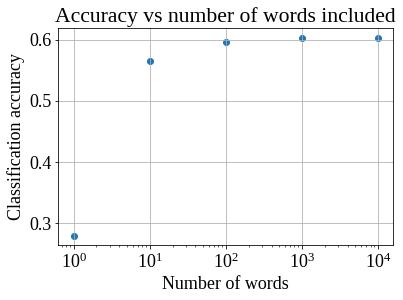

In [73]:
# Build confusion matrix for classification
def get_conf_mat(tfidf_: dict=None):
    conf_mat = np.zeros((len(loved_languages), len(loved_languages)), dtype=int)
    lang_indices = { lang: i for i, lang in enumerate(loved_languages) }
    for lang, i in lang_indices.items():
        texts = validation_texts[lang]
        for words in texts:
            pred, _ = classify(" ".join(words), tfidf_=tfidf_)
            if pred is not None:
                conf_mat[lang_indices[pred], i] += 1
    return conf_mat

# TODO: Multiclass F1
n = 5
number_of_words = np.logspace(0, n-1, n, dtype=int)
accs = list()
for n_words in tqdm(number_of_words):
    tfidf_ = { lang: top(tfidf[lang], n_words) for lang in tfidf }
    conf_mat = get_conf_mat(tfidf_)
    acc = np.diagonal(conf_mat).sum() / conf_mat.sum()
    accs.append(acc)
plt.scatter(number_of_words, accs)
plt.xscale("log")
plt.grid()
plt.title("Accuracy vs number of words included")
plt.xlabel("Number of words")
plt.ylabel("Classification accuracy")


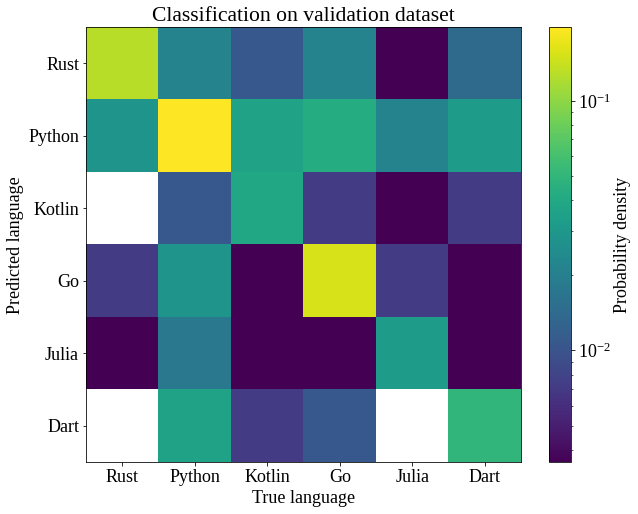

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
pos = ax.imshow(conf_mat/conf_mat.sum(), norm=mpl.colors.LogNorm())
ax.set_xticks(range(len(loved_languages)))
ax.set_xticklabels([lang.capitalize() for lang in loved_languages])
ax.set_yticks(range(len(loved_languages)))
ax.set_yticklabels([lang.capitalize() for lang in loved_languages])
ax.set_title("Classification on validation dataset")
ax.set_xlabel("True language")
ax.set_ylabel("Predicted language")
bar = fig.colorbar(pos)
bar.set_label("Probability density")